# PyTorch Basics for Probabilistic Modeling

Welcome! This notebook introduces the fundamental concepts of PyTorch that are essential for building not just neural networks, but also for working with probabilistic models and reinforcement learning agents.

We will cover:
1.  **Tensors**: The core data structure of PyTorch.
2.  **Automatic Differentiation**: How PyTorch calculates gradients automatically with `autograd`.
3.  **Probability Distributions & Sampling**: Using the `torch.distributions` package.
4.  **Building a Simple Bayesian Model**: A hands-on example to put everything together.

Understanding these basics will provide a strong foundation before you dive into building complex neural networks for RL in the next tutorial.

## Part 1: PyTorch Tensors

A **tensor** is a multi-dimensional array, similar to NumPy's `ndarray`. Tensors are the fundamental building block of PyTorch.

Let's start by importing `torch` and creating some tensors.

In [1]:
import torch
import numpy as np

# Create a tensor from a Python list
x = torch.tensor([[1, 2], [3, 4]])
print(f"Tensor from list:\n {x}\n")

# Create a tensor from a NumPy array
numpy_array = np.array([[5, 6], [7, 8]])
y = torch.from_numpy(numpy_array)
print(f"Tensor from NumPy array:\n {y}\n")

# Create a tensor of zeros
z = torch.zeros(2, 3)
print(f"Zeros tensor:\n {z}\n")

# Create a tensor of random numbers
r = torch.rand(2, 2)
print(f"Random tensor:\n {r}\n")

# Tensor operations
# Addition
total = x + y
print(f"Sum of tensors:\n {total}\n")

# Multiplication (element-wise)
product = x * y
print(f"Product of tensors:\n {product}\n")

Tensor from list:
 tensor([[1, 2],
        [3, 4]])

Tensor from NumPy array:
 tensor([[5, 6],
        [7, 8]])

Zeros tensor:
 tensor([[0., 0., 0.],
        [0., 0., 0.]])

Random tensor:
 tensor([[0.2810, 0.7662],
        [0.2598, 0.6748]])

Sum of tensors:
 tensor([[ 6,  8],
        [10, 12]])

Product of tensors:
 tensor([[ 5, 12],
        [21, 32]])



## Part 2: Automatic Differentiation with `torch.autograd`

A key feature of PyTorch is its ability to automatically compute gradients. This is handled by the `autograd` package. When you create a tensor, you can set `requires_grad=True`, which tells PyTorch to track all operations on it.

When you finish your computation, you can call `.backward()` on the result (which should be a scalar), and PyTorch will automatically compute the gradients of that result with respect to all tensors that have `requires_grad=True`. You can then access the gradients through the `.grad` attribute.

Let's see a simple example. Suppose we have a function `y = x^2`. The derivative of `y` with respect to `x` is `2x`. Let's verify this with PyTorch.

In [2]:
# Create a tensor with requires_grad=True
x = torch.tensor(3.0, requires_grad=True)
print(f"x = {x}")

# Define a simple quadratic function
y = x**2
print(f"y = x^2 = {y}")

# Compute the gradient
y.backward()

# The gradient is stored in x.grad
print(f"dy/dx at x=3 is: {x.grad}")

x = 3.0
y = x^2 = 9.0
dy/dx at x=3 is: 6.0


In [23]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
print(f"Tensor with name: {x.name}")

def f(x):
    return -4 * torch.sqrt(x**5) + 1/2

y = f(x)
print(f"Function output: {y}")

# Specify the gradient for each element
print(f"y's: {y}")

print(f"Gradient of the function at x: {x.grad}")


Tensor with name: None
Function output: tensor([  -3.5000,  -22.1274,  -61.8538, -127.5000], grad_fn=<AddBackward0>)
y's: tensor([  -3.5000,  -22.1274,  -61.8538, -127.5000], grad_fn=<AddBackward0>)
Gradient of the function at x: tensor([-10.0000, -28.2843, -51.9615, -80.0000])


For a function $L = f(y)$, where $y = g(x)$, the chain rule states that:
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x} $$

Let's say we have inputs w and x, and we compute a scalar loss L. $$ L = (w \cdot x)^2 = (w_1x_1 + w_2x_2)^2 $$ We want to find the partial derivatives $\frac{\partial L}{\partial w_1}$ and $\frac{\partial L}{\partial w_2}$.

In [24]:
# Tensors we want to compute gradients for
w = torch.tensor([0.5, 2.0], requires_grad=True)
x = torch.tensor([10.0, 1.0]) # We don't need gradients for x

# 1. Forward pass: build the computational graph
y = torch.dot(w, x) # y = 0.5*10 + 2*1 = 7
L = y**2            # L = 7^2 = 49

# 2. Backward pass: compute gradients
# Since L is a scalar, we can just call backward()
L.backward()

# 3. Check the computed gradients
print(w.grad)

tensor([140.,  14.])


Manual Calculation: Using the chain rule:

- $\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial w_1} = (2y) \cdot (x_1) = (2 \cdot 7) \cdot 10 = 140$
- $\frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial w_2} = (2y) \cdot (x_2) = (2 \cdot 7) \cdot 1 = 14$

If y = f(x) where x = [x_1, ..., x_n] and y = [y_1, ..., y_m], the Jacobian J is: 
$$ J = 
    \begin{pmatrix} 
        \frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \ \vdots & \ddots & \vdots \ \frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n} 
    \end{pmatrix} 
$$

Computing and storing a full Jacobian is very inefficient, and in deep learning, we almost never need it. We usually need the gradient of a final scalar loss L with respect to x. If L is a function of y, the chain rule gives us: $$ \nabla_x L = J^T \cdot \nabla_y L $$ This is a Jacobian-vector product.

This is what y.backward(v) does. It avoids computing the full Jacobian J. Instead, it directly computes the product of its transpose with a vector v that you provide. This vector v represents the gradient of the final loss with respect to y, i.e., v = \nabla_y L.



Once you have the scalar L, calling L.backward() computes the partial derivative of L with respect to all the model's parameters (weights and biases) via the chain rule, all the way back through the network.

In [25]:
from torch import nn

# --- Setup ---
batch_size = 4
num_classes = 3
num_features = 5

# A simple linear model (represents the last layer of a NN)
model = nn.Linear(num_features, num_classes)

# Dummy input data (4 items, 5 features each)
# requires_grad=False because we don't differentiate w.r.t. input data
# default: requires_grad=False
x = torch.randn(batch_size, num_features) 
print("Input data x:\n", x)

# Dummy true labels (4 items, one correct class for each)
# These are class indices (0, 1, or 2)
y_true = torch.tensor([1, 0, 2, 1]) 

# The standard loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss() # Note: This combines LogSoftmax and NLLLoss

# --- Forward Pass ---

# 1. Get the model's raw output (logits)
# The output is a VECTOR for each input item.
# Shape: [batch_size, num_classes] -> [4, 3]
y_pred = model(x)

print("Model Output (Logits) Shape:", y_pred.shape)
print("Model Output (Logits):\n", y_pred)
print("-" * 30)

# 2. Calculate the loss.
# The loss function takes the logit matrix and the true labels...
# ...and returns a SINGLE SCALAR value.
loss = loss_fn(y_pred, y_true) # apply loss function on vectors

print("Final Loss (Scalar):", loss)
print("Final Loss Shape:", loss.shape) # It has no shape, it's a scalar
print("-" * 30)


# --- Backward Pass ---

# 3. Backpropagate from the scalar loss
# This is possible because `loss` is a single number.
loss.backward()

# 4. Check the gradients that have been computed for the model's parameters
print("Gradients for model weights:\n", model.weight.grad)
print("Gradients for model bias:\n", model.bias.grad)

Input data x:
 tensor([[ 0.5239, -0.4162,  1.2000, -0.7539,  0.9040],
        [ 0.1751, -0.4988,  1.6313,  0.1427, -1.3289],
        [ 0.3678,  0.7330,  0.3596,  0.7808, -0.5951],
        [ 1.1628,  0.5924,  0.6825,  0.8924,  0.1645]])
Model Output (Logits) Shape: torch.Size([4, 3])
Model Output (Logits):
 tensor([[ 0.1349, -0.4942,  0.4314],
        [ 0.1952,  0.5746,  0.9641],
        [ 0.3426, -0.2033,  0.3854],
        [ 0.0212, -0.7002,  0.1996]], grad_fn=<AddmmBackward0>)
------------------------------
Final Loss (Scalar): tensor(1.4614, grad_fn=<NllLossBackward0>)
Final Loss Shape: torch.Size([])
------------------------------
Gradients for model weights:
 tensor([[ 0.1547,  0.1867, -0.1174,  0.0642,  0.2974],
        [-0.3106, -0.0355, -0.2352,  0.0253, -0.3558],
        [ 0.1559, -0.1512,  0.3526, -0.0895,  0.0584]])
Gradients for model bias:
 tensor([ 0.0795, -0.2741,  0.1945])


Logits are the raw, unnormalized scores from the last layer of a NN. They can be converted to probabilities using the softmax function, which normalizes the logits so that they sum to 1.

In [26]:
import torch.nn.functional as F
# Imagine these are the raw outputs from the last layer of your model for a single input.
# The model is trying to classify something into one of 4 classes.
# Class 2 has the highest score, so the model is most confident about it.
logits = torch.tensor([1.0, -2.0, 3.5, 0.5])

# Apply the softmax function to convert logits to probabilities
probabilities = F.softmax(logits, dim=0)

print("Logits (raw scores):", logits)
print("Probabilities (after softmax):", probabilities)
print("Sum of probabilities:", probabilities.sum())

Logits (raw scores): tensor([ 1.0000, -2.0000,  3.5000,  0.5000])
Probabilities (after softmax): tensor([0.0723, 0.0036, 0.8803, 0.0438])
Sum of probabilities: tensor(1.0000)


## Part 3: Probability Distributions and Sampling

PyTorch has a dedicated `distributions` package that is incredibly useful for probabilistic modeling and reinforcement learning. It allows you to create objects that represent probability distributions, from which you can sample values and compute log probabilities.

This is essential for building RL agents that need to explore by taking random actions, or for Bayesian models where we work with distributions over parameters.

Let's explore two common distributions:
*   `Categorical`: For discrete actions (like in `CartPole`).
*   `Normal`: For continuous actions (like in `InvertedPendulum`).

In [31]:
from torch.distributions import Categorical, Normal

# --- Categorical Distribution ---
print("--- Categorical Distribution ---")
# Let's say a policy network gives us these probabilities for 3 actions
action_probs = torch.tensor([0.1, 0.6, 0.3])
# Create a categorical distribution
m = Categorical(action_probs)
print(f"Categorical probabilities: {m.probs}")

# Sample an action
action_sampled = m.sample()
print(f"Sampled action: {action_sampled}")

# Get the log probability of the sampled action
log_prob = m.log_prob(action_sampled) # selects the probability of the sampled action and computes its log
print(f"Log probability of action {action_sampled}: {log_prob}\n")


# --- Normal (Gaussian) Distribution ---
print("--- Normal Distribution ---")
# Let's say a policy network gives us a mean and standard deviation
mu = torch.tensor(0.0)
sigma = torch.tensor(1.0)
# Create a normal distribution
n = Normal(mu, sigma)

# Sample a continuous action
action_continuous = n.sample()
print(f"Sampled continuous action: {action_continuous}")

# Get the log probability of this action
log_prob_continuous = n.log_prob(action_continuous)
print(f"Log probability of continuous action: {log_prob_continuous}")

--- Categorical Distribution ---
Categorical probabilities: tensor([0.1000, 0.6000, 0.3000])
Sampled action: 1
Log probability of action 1: -0.5108255743980408

--- Normal Distribution ---
Sampled continuous action: 1.6256550550460815
Log probability of continuous action: -2.2403156757354736


In [54]:
# z-score probability
z_score = (torch.tensor(3.0) - mu) / sigma
probability = n.cdf(z_score)  # Cumulative distribution function at x
print(f"Probability of z-score 3.0: {probability:.4f}")

Probability of z-score 3.0: 0.9987


## Part 4: Building a Simple Bayesian Model

Let's combine what we've learned to build a very simple probabilistic model. We'll perform Bayesian linear regression.

The goal of linear regression is to find the parameters `w` (weight) and `b` (bias) for a line `y = w*x + b` that best fits some data.

In a Bayesian approach, we don't find single values for `w` and `b`. Instead, we find *distributions* over `w` and `b` that are consistent with the data. We'll use gradient descent to find the parameters of these distributions.

**Our Model:**
*   We'll assume the data `y` is generated by `y = w*x + b + noise`, where the noise is normally distributed.
*   Our prior belief is that `w` and `b` are themselves drawn from Normal distributions.
*   We want to find the `mean` and `std` for the distributions of `w` and `b`.

### Exercise: Bayesian Linear Regression

Your task is to fill in the missing code to implement Bayesian linear regression.

You will need to:
1.  Define the parameters of our distributions for `w` and `b` (their means and log_stds). These are the parameters we will learn.
2.  In the training loop, sample `w` and `b` from their respective Normal distributions.
3.  Calculate the predicted `y` using the sampled `w` and `b`.
4.  Define the likelihood of the observed data given our prediction. This is also a Normal distribution.
5.  Calculate the **log probability** of the data under the model. This is our loss function (we want to maximize it, so we'll minimize its negative).
6.  Use `autograd` to compute gradients and update the distribution parameters.

**Use of Log-Standard Deviations**:
-   instead of fixed point coefficients, we learn the distribution parameters $(\mu, \sigma)$ of the normal distribution
-   we use logs of the standard deviation because
    -   enfoces non-negativity constraing (there exist no negative stdev)
    -   numerically stable (range of values remains relatively small)
    -   prevents probability collapse/explosion

Epoch 0, Loss: 24251.5234
Epoch 200, Loss: 4886.2837
Epoch 400, Loss: 731.8140
Epoch 600, Loss: 1146.5286
Epoch 800, Loss: 221.1716
Epoch 1000, Loss: 297.8305
Epoch 1200, Loss: 321.3020
Epoch 1400, Loss: 232.2034
Epoch 1600, Loss: 397.5685
Epoch 1800, Loss: 264.4166

Learned parameters for the distributions:
w_mean: 2.4699 (True: 2.5)
w_std: 0.2403
b_mean: 0.6332 (True: 0.5)
b_std: 0.2675


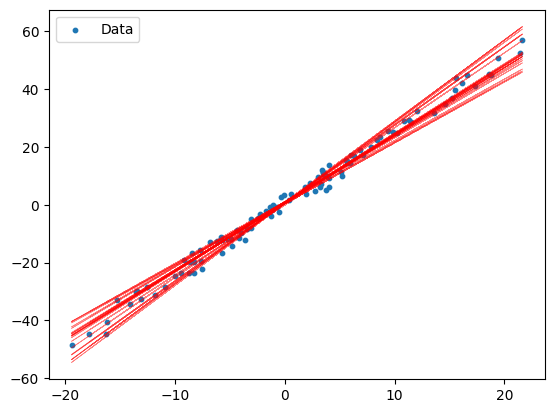

In [57]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate some synthetic data
true_w = 2.5
true_b = 0.5
X = torch.randn(100, 1) * 10
y = true_w * X + true_b + torch.randn(100, 1) * 2

# --- Your Code Here ---
# 1. Define the parameters we want to learn for our distributions.
# We need a mean and a log_std for w, and a mean and a log_std for b.
# Initialize them with some values. Use requires_grad=True.
w_mean = torch.tensor(0.0, requires_grad=True)
w_log_std = torch.tensor(1., requires_grad=True)# ... Fill in the missing code
b_mean = torch.tensor(1., requires_grad=True)# ... Fill in the missing code
b_log_std = torch.tensor(1., requires_grad=True)# ... Fill in the missing code

# Use the Adam optimizer to learn these parameters
optimizer = optim.Adam([w_mean, w_log_std, b_mean, b_log_std], lr=0.01)

for epoch in range(2000):
    optimizer.zero_grad()
    
    # 2. Create Normal distributions for w and b using their means and stds
    # Remember to exponentiate the log_std to get the std
    w_dist = Normal(w_mean, torch.exp(w_log_std))
    b_dist = Normal(b_mean, torch.exp(b_log_std))# ... Fill in the missing code
    
    # Sample from the distributions
    w_sample = w_dist.rsample() # rsample() allows gradients to flow
    b_sample = b_dist.rsample()# ... Fill in the missing code
    
    # 3. Calculate the predicted y
    y_pred = w_sample * X + b_sample # ... Fill in the missing code
    
    # 4. Define the likelihood distribution
    # Assume a fixed noise level for simplicity
    likelihood = Normal(y_pred, 2.0) # stdev of 2
    
    # 5. Calculate the negative log probability of the true data
    # This is our loss. We want to maximize the probability, so we minimize the negative log prob.
    log_prob = likelihood.log_prob(y).sum()
    loss = -log_prob
    
    # 6. Backpropagate and update the parameters
    loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# --- End of Your Code ---

# Print the learned parameters
print("\nLearned parameters for the distributions:")
print(f"w_mean: {w_mean.item():.4f} (True: {true_w})")
print(f"w_std: {torch.exp(w_log_std).item():.4f}")
print(f"b_mean: {b_mean.item():.4f} (True: {true_b})")
print(f"b_std: {torch.exp(b_log_std).item():.4f}")

# Plot the results
plt.scatter(X.numpy(), y.numpy(), s=10, label="Data")
# Plot 20 lines sampled from our learned distributions
for _ in range(20):
    w = Normal(w_mean, torch.exp(w_log_std)).sample()
    b = Normal(b_mean, torch.exp(b_log_std)).sample()
    plt.plot(X.numpy(), (w * X + b).detach().numpy(), linewidth=0.5, color='r', alpha=0.5)
plt.legend()
plt.show()

## Part 5: Case Study - Causal Inference with Time-Varying Coefficients

This section puts everything together in a challenging, real-world inspired case study. We will simulate a time-series dataset and build a Bayesian model to uncover the underlying dynamics.

### The Scenario

Imagine you are a data scientist at a company that uses 5 different marketing channels to drive sales. You need to figure out how effective each channel is. However, the world is not static:
1.  **Effectiveness Drifts:** The impact of a marketing channel can change over time due to market saturation, competition, or changing customer behavior.
2.  **Confounding Variables:** There are external factors you don't observe (e.g., a competitor's campaign, a news event, improving economic conditions) that affect both your marketing spend and your sales. For example, you might spend more on marketing during a holiday season, but sales also naturally go up then.

**Our Goal:**
Estimate the **time-varying causal effect** of each of the 5 marketing channels on sales, while accounting for trend, seasonality, and the unobserved confounders.

### The Model: Bayesian Regression with a Random Walk Prior

To solve this, we will build a Bayesian regression model where the coefficients (the "effects") are not fixed but are allowed to evolve over time.

-   **Likelihood:** The sales at time `t` are assumed to be normally distributed around a mean determined by the marketing spend and other factors.
    $Sales_t \sim \mathcal{N}(\mu_t, \sigma_{noise})$
    $\mu_t = \text{trend}_t + \text{seasonality}_t + \sum_{i=1}^{5} \beta_{i,t} \cdot \text{MarketingSpend}_{i,t}$

-   **Time-Varying Coefficients (Prior):** We model each coefficient $\beta_{i,t}$ as a random walk. This means the coefficient at time `t` is just the coefficient at time `t-1` plus some small noise. This enforces smoothness.
    $\beta_{i,t} \sim \mathcal{N}(\beta_{i, t-1}, \sigma_{drift})$

Instead of learning a single value for each $\beta_i$, we will learn an entire trajectory of values, one for each day. We will use variational inference (the same gradient-based optimization you used in Part 4) to find the most likely trajectories for all the coefficients.

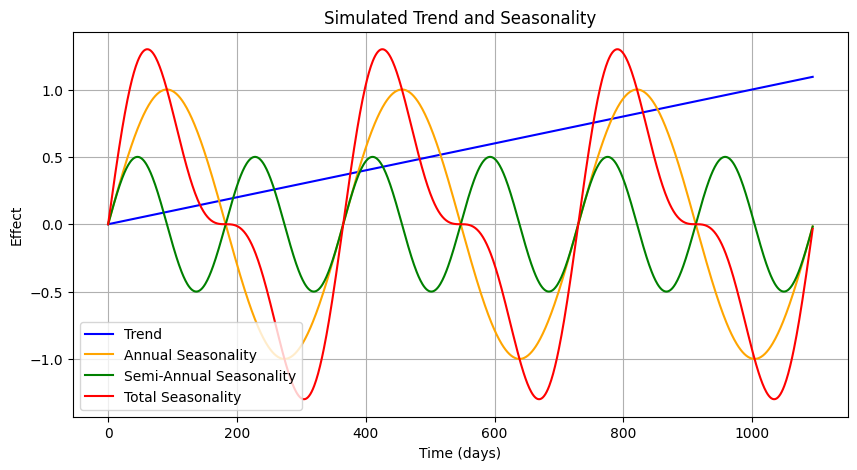

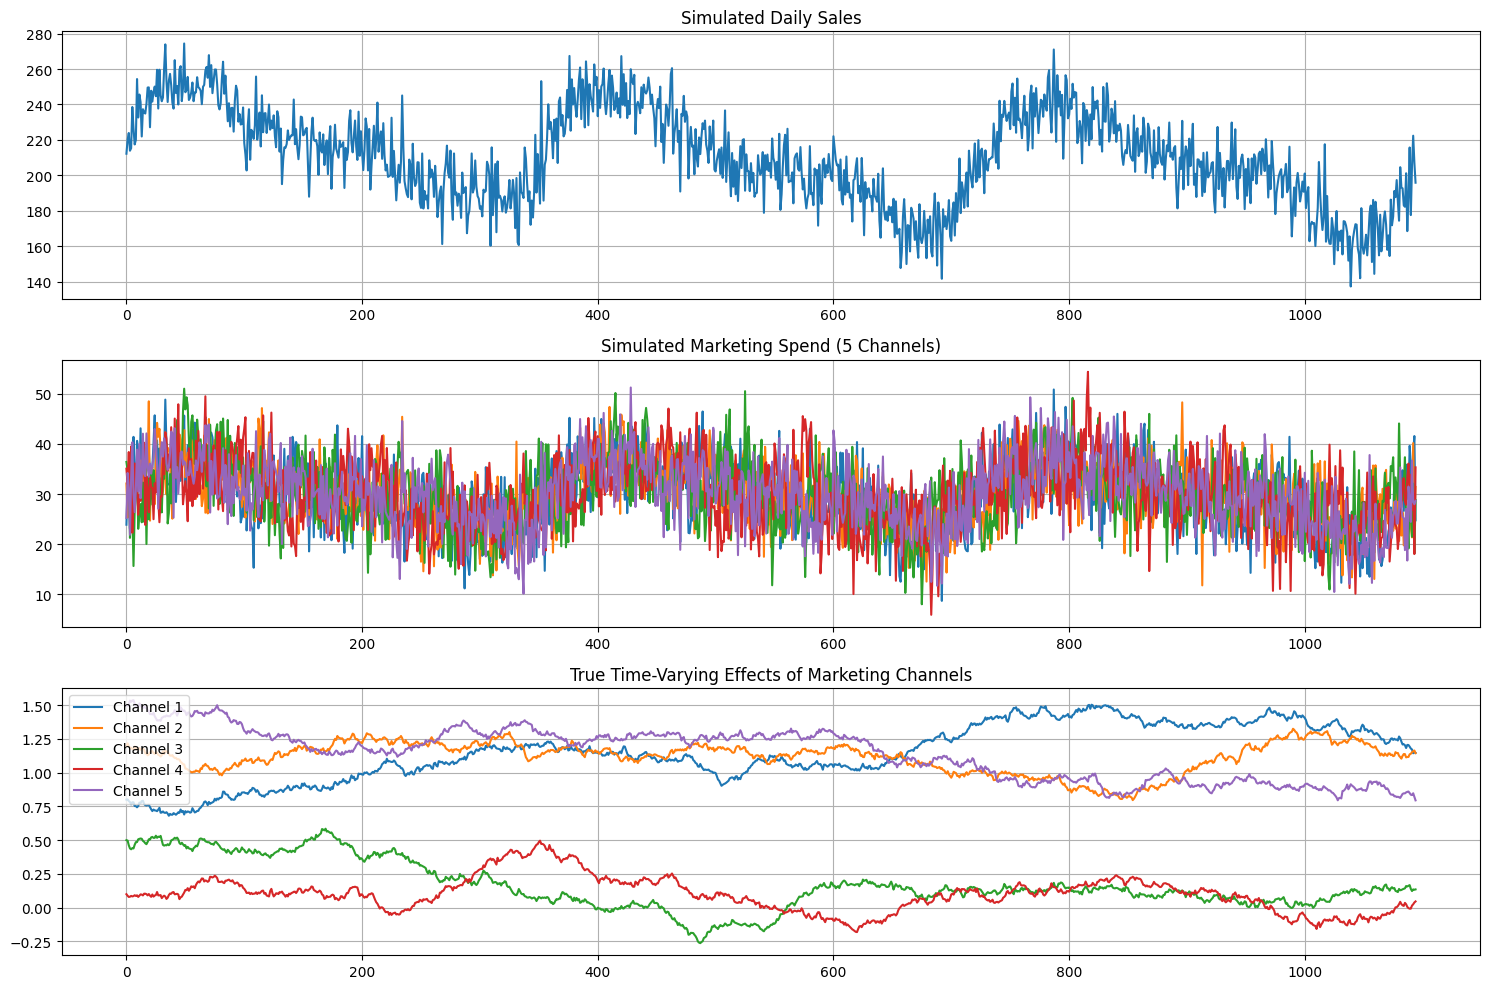

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Setup ---
T = 365 * 3  # 3 years of daily data
time = torch.arange(T, dtype=torch.float32)
n_channels = 5
n_confounders = 4

# --- 2. Simulate Trend and Seasonality ---
trend = 0.001 * time
annual_seasonality = torch.sin(2 * np.pi * time / 365)
semi_annual_seasonality = 0.5 * torch.sin(4 * np.pi * time / 365)
seasonality = annual_seasonality + semi_annual_seasonality

plt.figure(figsize=(10, 5))
plt.plot(time.numpy(), trend.numpy(), label='Trend', color='blue')
plt.plot(time.numpy(), annual_seasonality.numpy(), label='Annual Seasonality', color='orange')
plt.plot(time.numpy(), semi_annual_seasonality.numpy(), label='Semi-Annual Seasonality', color='green')
plt.plot(time.numpy(), seasonality.numpy(), label='Total Seasonality', color='red')
plt.legend()
plt.title("Simulated Trend and Seasonality")
plt.xlabel("Time (days)")
plt.ylabel("Effect")
plt.grid(True)
plt.show()

# --- 3. Simulate Time-Varying Coefficients (The "True" Effects) ---
# We model these as a random walk, which we will try to recover.
true_betas_channels = torch.zeros(T, n_channels)
true_betas_confounders = torch.zeros(T, n_confounders)

# Initial values for the coefficients
true_betas_channels[0] = torch.tensor([0.8, 1.2, 0.5, 0.1, 1.5])
true_betas_confounders[0] = torch.tensor([1.07, -0.85, 1.4, 0.66])

# The "drift" or daily change in the coefficients' effects
channel_drift_scale = 0.013
confounder_drift_scale = 0.02
for t in range(1, T):
    true_betas_channels[t] = true_betas_channels[t-1] + torch.randn(n_channels) * channel_drift_scale
    true_betas_confounders[t] = true_betas_confounders[t-1] + torch.randn(n_confounders) * confounder_drift_scale

# --- 4. Simulate Unobserved Confounders and Marketing Spend ---
# The confounders influence both marketing spend and sales.
confounders = torch.zeros(T, n_confounders)
for i in range(n_confounders):
    confounders[:, i] = torch.sin(2 * np.pi * time / (30 * (i+1))) + torch.randn(T) * 0.2

# Marketing spend is influenced by seasonality and the unobserved confounders
marketing_spend = (
    torch.abs(seasonality.unsqueeze(1) * 5 + 10) + # Base spend driven by seasonality
    confounders @ torch.randn(n_confounders, n_channels) * 2 + # Confounding effect
    torch.randn(T, n_channels) * 5 + 20 # Base random spend
)

# --- 5. Simulate Sales (The Target Variable) ---
# Sales = trend + seasonality + effect of marketing + effect of confounders + noise
effect_of_marketing = (marketing_spend * true_betas_channels).sum(axis=1)
effect_of_confounders = (confounders * true_betas_confounders).sum(axis=1)
noise = torch.randn(T) * 5.0

sales = 100 + trend + seasonality * 10 + effect_of_marketing + effect_of_confounders + noise

# --- Visualization of Simulated Data ---
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.title("Simulated Daily Sales")
plt.plot(sales.numpy())
plt.grid(True)

plt.subplot(3, 1, 2)
plt.title("Simulated Marketing Spend (5 Channels)")
plt.plot(marketing_spend.numpy())
plt.grid(True)

plt.subplot(3, 1, 3)
plt.title("True Time-Varying Effects of Marketing Channels")
plt.plot(true_betas_channels.numpy())
plt.legend([f'Channel {i+1}' for i in range(n_channels)], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Starting model training...
Epoch 0, Loss: 9489856.00
Epoch 1000, Loss: 1224.42
Epoch 2000, Loss: -11459.29
Epoch 3000, Loss: -17288.39
Epoch 4000, Loss: -22835.62
Epoch 5000, Loss: -24133.70
Epoch 6000, Loss: -28635.10
Epoch 7000, Loss: -26642.12
Epoch 8000, Loss: 16106.84
Epoch 9000, Loss: -31565.51
Training finished.


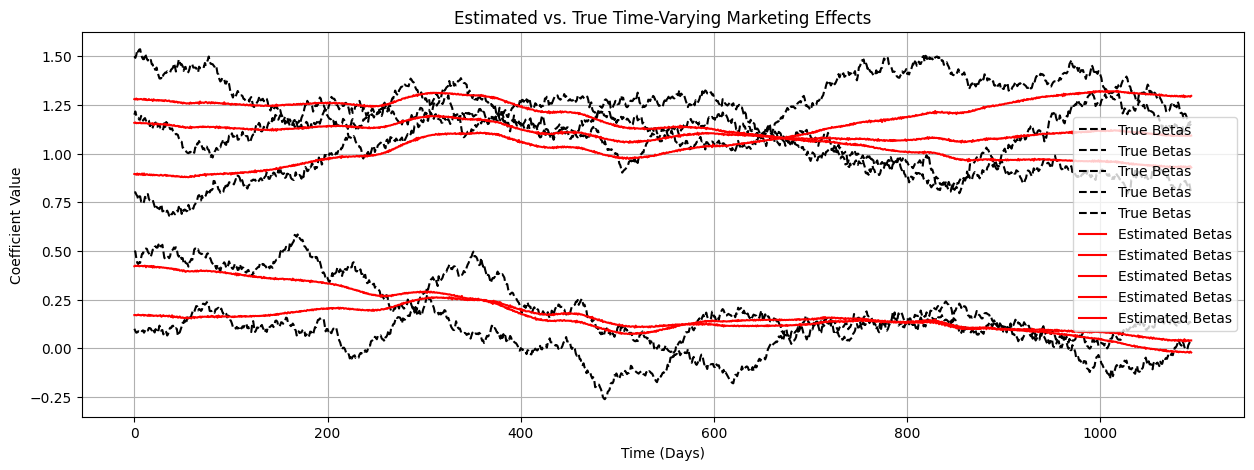

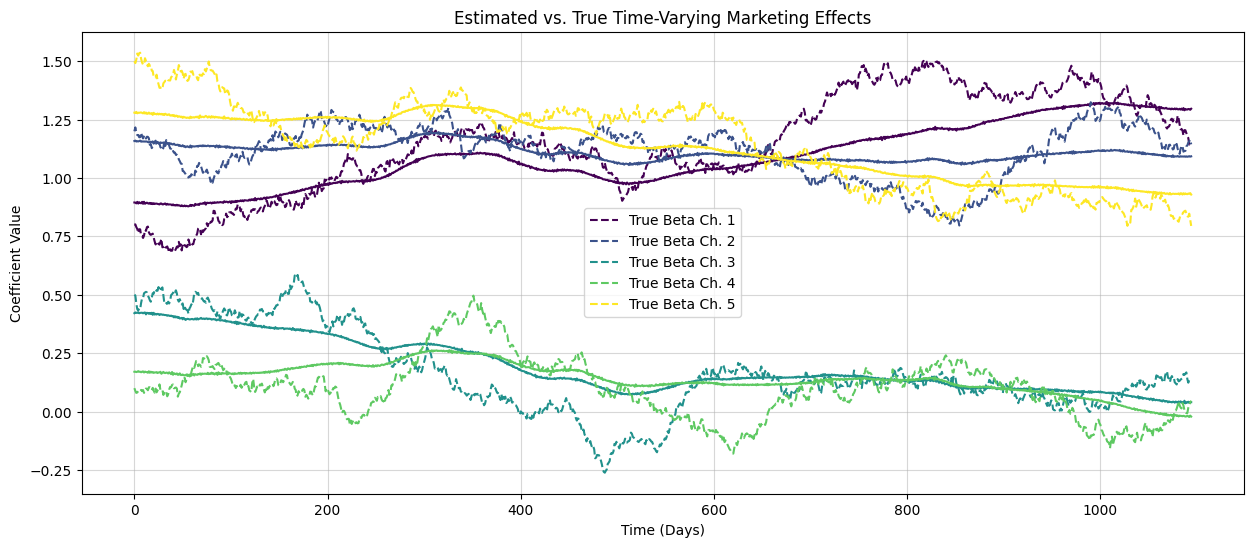

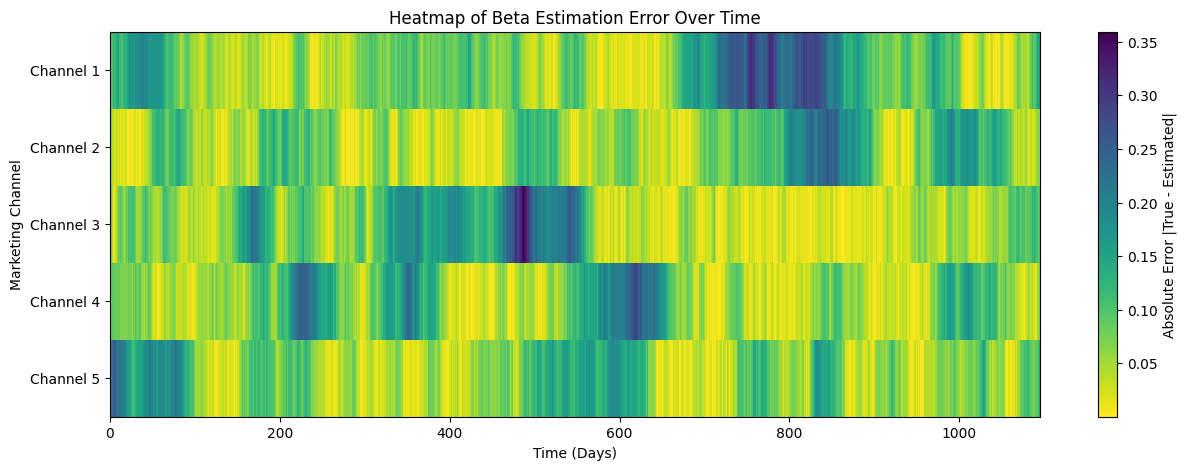

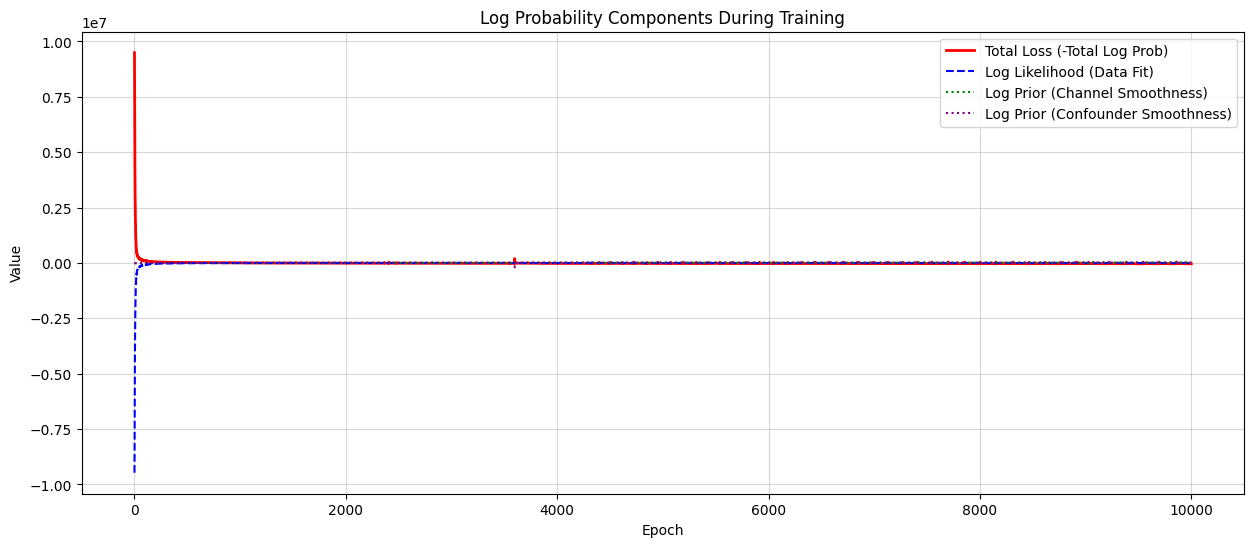

In [76]:
import torch
import torch.optim as optim
from torch.distributions import Normal

torch.manual_seed(1)

# --- Model Parameters ---
# We need to learn the mean and std for the entire trajectory of each coefficient.
# Shape: [T, n_channels] for marketing betas, [T, n_confounders] for confounder betas.
# We initialize them at zero and let the optimizer find the right values.
beta_channels_mean = torch.zeros(T, n_channels, requires_grad=True)
beta_channels_log_std = torch.zeros(T, n_channels, requires_grad=True)

# We also model the confounders' effects to properly isolate the marketing effect
beta_confounders_mean = torch.zeros(T, n_confounders, requires_grad=True)
beta_confounders_log_std = torch.zeros(T, n_confounders, requires_grad=True)

# We also learn the drift scales and the noise level
log_drift_scale_channels = torch.tensor(0.0, requires_grad=True)
log_drift_scale_confounders = torch.tensor(0.0, requires_grad=True)
log_noise = torch.tensor(0.0, requires_grad=True)

# --- Training Setup ---
# We include all learnable parameters in the optimizer
optimizer = optim.Adam([
    beta_channels_mean, beta_channels_log_std,
    beta_confounders_mean, beta_confounders_log_std,
    log_drift_scale_channels, log_drift_scale_confounders, log_noise
], lr=0.05)

loss_history = []
log_likelihood_history = []
log_prior_channels_history = []
log_prior_confounders_history = []

print("Starting model training...")
for epoch in range(10_000):
    optimizer.zero_grad()
    
    # --- 1. Sample coefficient trajectories using the reparameterization trick ---
    # This is how we sample from our learned distributions while allowing gradients to flow
    beta_channels_std = torch.exp(beta_channels_log_std)
    beta_channels_dist = Normal(beta_channels_mean, beta_channels_std)
    beta_channels_sample = beta_channels_dist.rsample()

    beta_confounders_std = torch.exp(beta_confounders_log_std)
    beta_confounders_dist = Normal(beta_confounders_mean, beta_confounders_std)
    beta_confounders_sample = beta_confounders_dist.rsample()
    
    # --- 2. Calculate the predicted sales ---
    pred_effect_marketing = (marketing_spend * beta_channels_sample).sum(axis=1)
    pred_effect_confounders = (confounders * beta_confounders_sample).sum(axis=1)
    
    # We treat trend and seasonality as known and fixed for simplicity
    mu_pred = 100 + trend + seasonality * 10 + pred_effect_marketing + pred_effect_confounders
    
    # --- 3. Calculate the Loss (Negative Log Probability) ---
    
    # Loss Part A: Likelihood of the data
    # How likely are the observed sales given our predicted sales?
    likelihood = Normal(mu_pred, torch.exp(log_noise))
    log_prob_likelihood = likelihood.log_prob(sales).sum()
    
    # Loss Part B: The Random Walk Prior
    # How likely are the coefficient trajectories, given our random walk assumption?
    # This penalizes sharp jumps in coefficients, enforcing smoothness.
    drift_scale_channels = torch.exp(log_drift_scale_channels)
    drift_scale_confounders = torch.exp(log_drift_scale_confounders)
    
    log_prob_prior_channels = Normal(beta_channels_sample[:-1], drift_scale_channels).log_prob(beta_channels_sample[1:]).sum()
    log_prob_prior_confounders = Normal(beta_confounders_sample[:-1], drift_scale_confounders).log_prob(beta_confounders_sample[1:]).sum()
    
    # Total log probability is the sum of all parts
    total_log_prob = log_prob_likelihood + log_prob_prior_channels + log_prob_prior_confounders
    
    # We want to MAXIMIZE the probability, so we MINIMIZE the negative log probability
    loss = -total_log_prob
    
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    log_likelihood_history.append(log_prob_likelihood.item())
    log_prior_channels_history.append(log_prob_prior_channels.item())
    log_prior_confounders_history.append(log_prob_prior_confounders.item())
    
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2f}")

print("Training finished.")

# --- Visualize Results ---
plt.figure(figsize=(15, 5))
plt.title("Estimated vs. True Time-Varying Marketing Effects")
# Plot true effects
plt.plot(true_betas_channels.numpy(), color='black', linestyle='--', label='True Betas')
# Plot estimated effects (the mean of our learned distributions)
plt.plot(beta_channels_mean.detach().numpy(), color='red', label='Estimated Betas')
plt.grid(True)
plt.xlabel("Time (Days)")
plt.ylabel("Coefficient Value")
plt.legend()
plt.show()

# PLOT 1: Improved Line Plot of Beta Trajectories
plt.figure(figsize=(15, 6))
plt.title("Estimated vs. True Time-Varying Marketing Effects")
# Get a color for each channel
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))

for i in range(n_channels):
    # Plot the true beta trajectory with a dashed line
    plt.plot(time.numpy(), true_betas_channels[:, i].numpy(), color=colors[i], linestyle='--', label=f'True Beta Ch. {i+1}')
    # Plot the estimated beta trajectory (the mean of our learned distribution) with a solid line
    plt.plot(time.numpy(), beta_channels_mean[:, i].detach().numpy(), color=colors[i])

plt.grid(True, alpha=0.5)
plt.xlabel("Time (Days)")
plt.ylabel("Coefficient Value")
plt.legend()
plt.show()


# PLOT 2: Heatmap of Estimation Error
# Calculate the absolute error between true and estimated beta means
absolute_error = torch.abs(true_betas_channels - beta_channels_mean.detach())

plt.figure(figsize=(15, 5))
# Use imshow to create a heatmap. We transpose the error matrix so time is on the x-axis.
im = plt.imshow(absolute_error.numpy().T, aspect='auto', cmap='viridis_r', interpolation='none')
plt.colorbar(im, label="Absolute Error |True - Estimated|")
plt.title("Heatmap of Beta Estimation Error Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Marketing Channel")
# Set the y-axis ticks to correspond to channel numbers
plt.yticks(ticks=range(n_channels), labels=[f"Channel {i+1}" for i in range(n_channels)])
plt.show()

# PLOT 3: Convergence Plot
plt.figure(figsize=(15, 6))
plt.title("Log Probability Components During Training")
plt.plot(loss_history, label="Total Loss (-Total Log Prob)", color='red', linewidth=2)
plt.plot(log_likelihood_history, label="Log Likelihood (Data Fit)", color='blue', linestyle='--')
plt.plot(log_prior_channels_history, label="Log Prior (Channel Smoothness)", color='green', linestyle=':')
plt.plot(log_prior_confounders_history, label="Log Prior (Confounder Smoothness)", color='purple', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

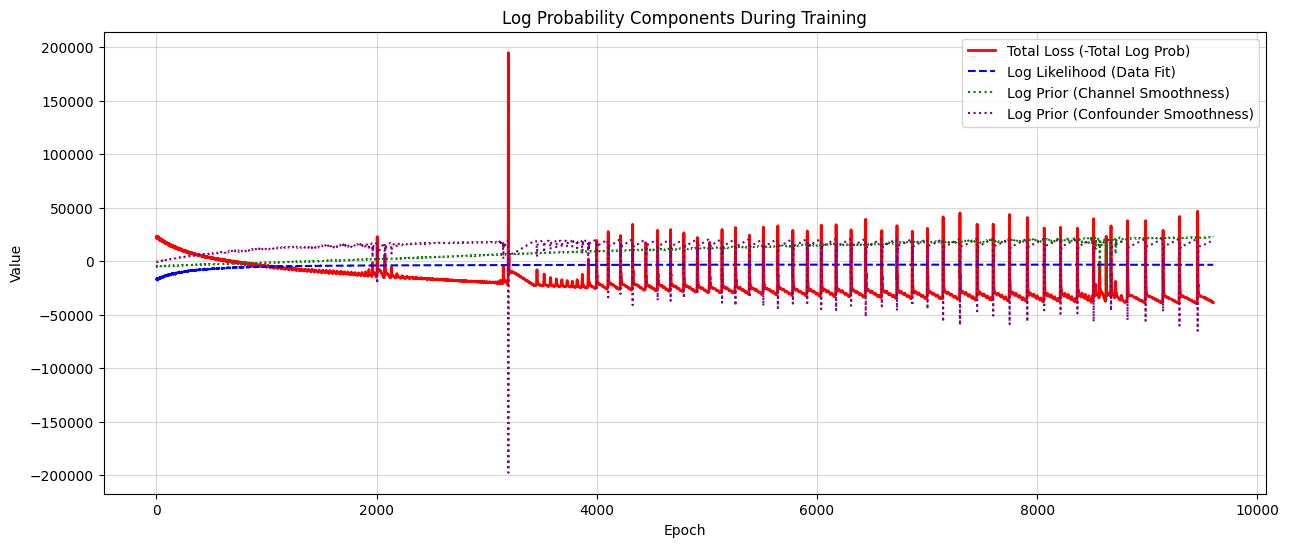

In [77]:
# PLOT 3: Convergence Plot
from_N = 400
plt.figure(figsize=(15, 6))
plt.title("Log Probability Components During Training")
plt.plot(loss_history[from_N:], label="Total Loss (-Total Log Prob)", color='red', linewidth=2)
plt.plot(log_likelihood_history[from_N:], label="Log Likelihood (Data Fit)", color='blue', linestyle='--')
plt.plot(log_prior_channels_history[from_N:], label="Log Prior (Channel Smoothness)", color='green', linestyle=':')
plt.plot(log_prior_confounders_history[from_N:], label="Log Prior (Confounder Smoothness)", color='purple', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()